In [10]:
# data manipulation
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# model
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier

# metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score

# saving
import joblib

In [2]:
# reading the datasets
X_train = pd.read_csv('data/x_train_processed.csv')
X_test = pd.read_csv('data/x_test.csv')
y_train = pd.read_csv('data/y_train.csv')
y_test = pd.read_csv('data/y_test.csv')

In [35]:
# preprocessing pipeline
preprocessing = joblib.load('models and parameters/preprocessing.pkl')

In [ ]:
# dataframe for the scores
scores = pd.DataFrame(columns=['ModelName', 'TrainAccuracy', 'ValidationAccuracy', 'Precision', 'Recall'])
scores.head()

,ModelName,TrainAccuracy,ValidationAccuracy,Precision,Recall


## Decision tree

In [14]:
# instantiating a decision tree
train_clf = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)
train_acc = train_clf.score(X_train, y_train)
validation_clf = DecisionTreeClassifier(random_state=42)
preds = cross_val_predict(validation_clf, X_train, y_train, cv=5)
scores.loc[len(scores)] = {
    'ModelName': 'BaseDecisionTree',
    'TrainAccuracy': train_acc,
    'ValidationAccuracy': accuracy_score(y_train, preds),
    'Precision': precision_score(y_train, preds, average='macro'),
    'Recall': recall_score(y_train, preds, average='macro')
}

In [15]:
scores.head()

,ModelName,TrainAccuracy,ValidationAccuracy,Precision,Recall
0,BaseDecisionTree,1.0,0.932323,0.891327,0.888877


In [23]:
# hypertuning the decision tree
params = {
    'max_depth': list(range(1, 100)) + [None],
    'max_leaf_nodes': list(range(2, 200)) + [None],
    'min_samples_split': [2, 4, 8, 12],
    'max_features': [None, 'sqrt', 'log2'],
    'random_state': [42]
}

In [31]:
clf = RandomizedSearchCV(DecisionTreeClassifier(), params, random_state=42, n_iter=20, n_jobs=-1, return_train_score=True, cv=5)
clf.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29, 30, ...],
                                        'max_features': [None, 'sqrt', 'log2'],
                                        'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8,
                                                           9, 10, 11, 12, 13,
                                                           14, 15, 16, 17, 18,
                                                           19, 20, 21, 22, 23,
                                                           24, 25, 26, 27, 28,
                                                           29, 30, 31, ...],
                                        'min_samples_split': [2, 4, 8, 12],
                                        'random_state': [42]},
                   random_state=42, return_train_score=True)

In [33]:
results = pd.DataFrame(clf.cv_results_)
results = results[['param_max_depth', 'param_min_samples_split', 'param_max_leaf_nodes',
                    'param_max_features', 'param_max_depth', 'mean_test_score', 'rank_test_score',
                    'mean_train_score']]
results.head(10)

,param_max_depth,param_min_samples_split,param_max_leaf_nodes,param_max_features,param_max_depth,mean_test_score,rank_test_score,mean_train_score
0,52,8,44,None,52,0.718684,10,0.719154
1,62,12,102,sqrt,62,0.712317,13,0.713620
2,56,2,150,None,56,0.758312,1,0.760966
3,44,8,55,sqrt,44,0.699153,17,0.699817
4,51,12,121,None,51,0.751599,4,0.753682
5,47,2,107,None,47,0.747094,5,0.749045
6,88,2,36,None,88,0.715530,11,0.716172
7,23,8,191,log2,23,0.712212,14,0.714447
8,58,4,108,sqrt,58,0.713759,12,0.715211
9,90,8,34,sqrt,90,0.692526,18,0.692814


In [36]:
# instantiating a decision tree
train_clf = clf.best_estimator_.fit(X_train, y_train)
train_acc = train_clf.score(X_train, y_train)
preds = cross_val_predict(clf.best_estimator_, X_train, y_train, cv=5)
scores.loc[len(scores)] = {
    'ModelName': 'TunedDecisionTree',
    'TrainAccuracy': train_acc,
    'ValidationAccuracy': accuracy_score(y_train, preds),
    'Precision': precision_score(y_train, preds, average='macro'),
    'Recall': recall_score(y_train, preds, average='macro')
}

In [37]:
scores.head()

,ModelName,TrainAccuracy,ValidationAccuracy,Precision,Recall
0,BaseDecisionTree,1.000000,0.932323,0.891327,0.888877
1,TunedDecisionTree,0.760463,0.758312,0.691005,0.593630


In the end, the best decision tree endend up being the one with less regularization, that is, the standard one you get when instantiating the decision tree classifier.

In [39]:
scores.to_csv('models and parameters/model_scores.csv', index=False)

In [40]:
best_tree = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

In [45]:
preds = best_tree.predict(preprocessing.transform(X_test))
print(classification_report(y_test, preds))

/Users/federico/miniconda3/envs/data-mining/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           1       0.94      0.94      0.94     42368
           2       0.95      0.95      0.95     56661
           3       0.93      0.93      0.93      7151
           4       0.84      0.85      0.84       549
           5       0.84      0.84      0.84      1899
           6       0.88      0.87      0.88      3473
           7       0.94      0.94      0.94      4102

    accuracy                           0.94    116203
   macro avg       0.90      0.90      0.90    116203
weighted avg       0.94      0.94      0.94    116203



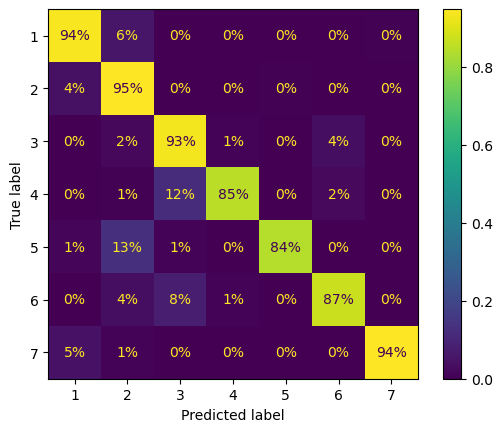

In [47]:
ConfusionMatrixDisplay.from_predictions(y_test, preds, normalize='true', values_format='.0%')
plt.show()

## KNN

In [8]:
params = {
    'n_neighbors': list(range(1, 21))
}

In [12]:
clf = GridSearchCV(KNeighborsClassifier(), params, n_jobs=-1, return_train_score=True, cv=5)
clf.fit(X_train, y_train)

c:\Users\T-Gamer\miniconda3\envs\data-mining\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20]},
             return_train_score=True)

In [27]:
results = pd.DataFrame(clf.cv_results_)
results = results[['rank_test_score', 'mean_train_score', 'mean_test_score', 'params']]
results['n_neighbors'] = results['params'].apply(lambda x: x['n_neighbors'])
results.head(10)

,rank_test_score,mean_train_score,mean_test_score,params,n_neighbors
0,1,1.000000,0.938541,{'n_neighbors': 1},1
1,5,0.970133,0.927906,{'n_neighbors': 2},2
2,2,0.970184,0.935335,{'n_neighbors': 3},3
3,4,0.959588,0.929356,{'n_neighbors': 4},4
4,3,0.957168,0.930712,{'n_neighbors': 5},5
5,6,0.950711,0.926600,{'n_neighbors': 6},6
6,7,0.947941,0.926200,{'n_neighbors': 7},7
7,8,0.943288,0.922598,{'n_neighbors': 8},8
8,9,0.940478,0.921484,{'n_neighbors': 9},9
9,10,0.936964,0.919068,{'n_neighbors': 10},10


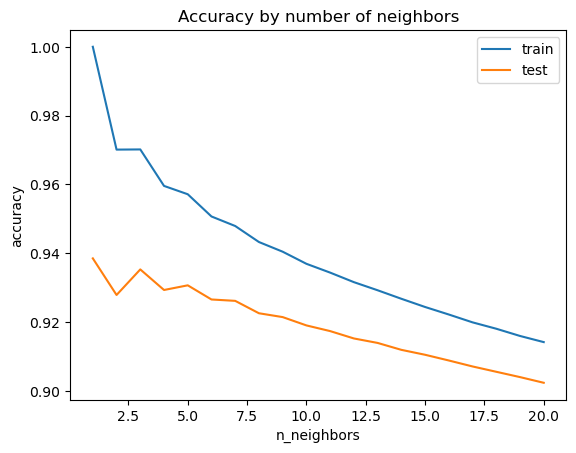

In [26]:
fig, axes = plt.subplots()
axes.plot(results['n_neighbors'], results['mean_train_score'], label='train')
axes.plot(results['n_neighbors'], results['mean_test_score'], label='test')
plt.xlabel('n_neighbors')
plt.ylabel('accuracy')
plt.title('Accuracy by number of neighbors')
plt.legend()
plt.show()

In [34]:
best_knn = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)

c:\Users\T-Gamer\miniconda3\envs\data-mining\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [36]:
preds = best_knn.predict(preprocessing.transform(X_test))
print(classification_report(y_test, preds))

c:\Users\T-Gamer\miniconda3\envs\data-mining\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           1       0.94      0.94      0.94     42368
           2       0.95      0.95      0.95     56661
           3       0.93      0.93      0.93      7151
           4       0.87      0.77      0.81       549
           5       0.85      0.82      0.84      1899
           6       0.87      0.87      0.87      3473
           7       0.95      0.95      0.95      4102

    accuracy                           0.94    116203
   macro avg       0.91      0.89      0.90    116203
weighted avg       0.94      0.94      0.94    116203



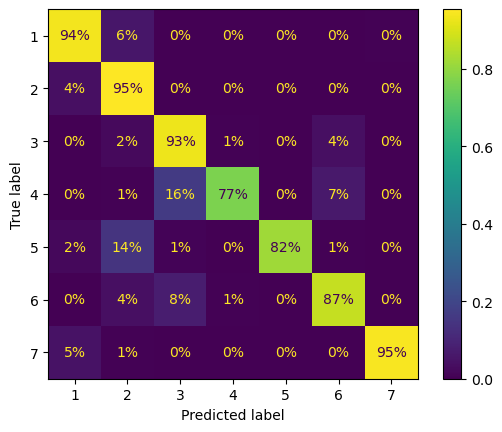

In [37]:
ConfusionMatrixDisplay.from_predictions(y_test, preds, normalize='true', values_format='.0%')
plt.show()

In [50]:
scores.head()

,ModelName,TrainAccuracy,ValidationAccuracy,Precision,Recall,TestAccuracy
0,BaseDecisionTree,1.000000,0.932323,0.891327,0.888877,0.94
1,TunedDecisionTree,0.760463,0.758312,0.691005,0.593630,NaN


In [53]:
scores.loc[len(scores)] = {
    'ModelName': 'KNN',
    'TrainAccuracy': best_knn.score(X_train, y_train),
    'ValidationAccuracy': results['mean_test_score'],
    'Precision': precision_score(y_test, preds, average='macro'),
    'Recall': recall_score(y_test, preds, average='macro'),
    'TestAccuracy': 0.94
}

In [62]:
scores.head()

,ModelName,TrainAccuracy,ValidationAccuracy,Precision,Recall,TestAccuracy
0,BaseDecisionTree,1.000000,0.932323,0.891327,0.888877,0.94
1,TunedDecisionTree,0.760463,0.758312,0.691005,0.593630,NaN
2,KNN,0.972610,0.935335,0.909849,0.888872,0.94


## LVQ